# Demo : Lunar Data

This is a walkthough of how to run the landmark tools for an example data set. All functions are also documented on the [Run](RUN.md) page. 

You can run this demo as a [jupyter notebook](https://docs.jupyter.org/en/latest/running.html). 

## Initialize the notebook environment

Edit the `BUILD_DIR` path to reflect your build directory. `"../build/Release/"` is the default for Xcode. If you are using cmake and you followed my setup instructions, your build directory is `"../build/"`

In [1]:
BUILD_DIR="../build/"
!echo $BUILD_DIR

PYTHON_SCRIPT_DIR="../scripts/python/landmark_tools/"
!echo $PYTHON_SCRIPT_DIR

!rm -r output/moon
!mkdir -p output/moon

../build/
../scripts/python/landmark_tools/


## Dependencies

This demo assumes you have already followed the steps to [Install the tools](INSTALL.md).

Please install [gdal](https://gdal.org/index.html) for manipulating GeoTIFFs.

For the python visualization scripts, you will need the following python libraries

- matplotlib
- numpy
- pillow

Reload the jupyter kernel after installing these libraries.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# This sys call is needed because the file is in another directory 
import sys
sys.path.insert(1, '../scripts/python/landmark_tools')
import visualize_corr
import landmark

plt.rcParams['figure.figsize'] = [8, 3]

## Source data

[Download Haworth Crater LDEM](https://pgda.gsfc.nasa.gov/data/LOLA_5mpp/Haworth/Haworth_final_adj_5mpp_surf.tif) from the [High-Resolution LOLA Topography for Lunar South Pole Sites](https://pgda.gsfc.nasa.gov/products/78) 

We're going to use this GeoTIFF to demonstrate most tools available in the landmark tools suite. 

In [3]:
#!wget https://pgda.gsfc.nasa.gov/data/LOLA_5mpp/Haworth/Haworth_final_adj_5mpp_surf.tif

We're also going to use the [Lunar LRO NAC Haworth Photoclinometry DEM](Lunar_LROnac_Haworth_sfs-dem_1m_v3.tif) for comparison.

In [4]:
#!wget https://planetarymaps.usgs.gov/mosaic/Lunar_Photoclinometry/Haworth-SfS/Lunar_LROnac_Haworth_sfs-dem_1m_v3.tif

Optionally, you can also browse for other data products on the [Moon Trek](https://trek.nasa.gov/moon/) website and [Lunar Orbital Data Explorer](https://ode.rsl.wustl.edu/moon/productsearch) website.

The tools can consume geotiff or PDS4 formats.

Let's look at the meta data for the files that we have downloaded so far.

In [5]:
!gdalinfo Haworth_final_adj_5mpp_surf.tif

Driver: GTiff/GeoTIFF
Files: Haworth_final_adj_5mpp_surf.tif
Size is 5960, 5960
Coordinate System is:
PROJCRS["unknown",
    BASEGEOGCRS["unknown",
        DATUM["unknown",
            ELLIPSOID["unknown",1737400,0,
                LENGTHUNIT["metre",1,
                    ID["EPSG",9001]]]],
        PRIMEM["Reference meridian",0,
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]],
    CONVERSION["Polar Stereographic (variant A)",
        METHOD["Polar Stereographic (variant A)",
            ID["EPSG",9810]],
        PARAMETER["Latitude of natural origin",-90,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",1,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",0,
            LENGTHUNIT["metr

In [6]:
!gdalinfo Lunar_LROnac_Haworth_sfs-dem_1m_v3.tif

Driver: GTiff/GeoTIFF
Files: Lunar_LROnac_Haworth_sfs-dem_1m_v3.tif
Size is 11660, 12060
Coordinate System is:
PROJCRS["PolarStereographic Moon",
    BASEGEOGCRS["D_Moon",
        DATUM["D_Moon",
            ELLIPSOID["Moon_polarRadius",1737400,0,
                LENGTHUNIT["metre",1,
                    ID["EPSG",9001]]]],
        PRIMEM["Reference_Meridian",0,
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]],
    CONVERSION["Polar Stereographic (variant A)",
        METHOD["Polar Stereographic (variant A)",
            ID["EPSG",9810]],
        PARAMETER["Latitude of natural origin",-90,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",1,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting"

## Let's get started

### Step 1. Convert GeoTIFF to a landmark file using create_landmark

First, let's take a look at the arguments for create_landmark

In [7]:
!$BUILD_DIR/create_landmark

Usage for create_landmark:
------------------
  Required arguments:
    -projection <EQ_CYLINDERICAL or UTM or STEREO or GEOGRAPHIC>
    -config_file <filename> - configuration file
  OR
    -geotif_file   <filename> - input dem tif file name
    -lmk_file   <filename> - output lmk file name
    -lmk_width_meters   <filename> - lmk col size
    -lmk_height_meters   <filename> - lmk row size
    -lmk_res   <filename> - lmk resolution
    -lmk_center_lat   <filename> - lmk center lat
    -lmk_center_long   <filename> - lmk center long
  Optional arguments:
    -planet <Moon or Earth> - (default Moon)
    -nodata_value <int> - (default NaN)
    -srm_file <filename> - png image file containing surface reflectance map
    -set_anchor_point_ele <float> - (default NAN, use ele based on a point at anchor lat long)
main() ==>> failed, missing all parameters


The first two options are for using a configuration file for binary image formats. The options after the OR describe the command line arguments that you can use for GeoTIFF files. Our first DEM is a GeoTIFF, so we'll start there. 

For our Haworth file, the arguments might look like this 

In [8]:
!$BUILD_DIR/create_landmark \
    -geotif_file Haworth_final_adj_5mpp_surf.tif \
    -lmk_file output/moon/Haworth_final_adj_5mpp_surf_tif.lmk \
    -lmk_width_meters 10000 \
    -lmk_height_meters 10000 \
    -lmk_res 10 \
    -lmk_center_lat -86.8 \
    -lmk_center_long 338.0

Polar Stereographic Projection Detected
Creating landmark with empty surface reflectance map.
 0.374606593416661  0.927183854566485  0.000000000000000
 0.925738159047660 -0.374022494511561  0.055821451811993
 0.051756748858541 -0.020911083902863 -0.998440767155269


It is also possible to convert geotiff using a configuration file. For this procedure, they must first be converted to a binary format, and a configuration file must be written

In [9]:
# Transform into headerless binary format like ENVI
!gdal_translate -r bilinear -of ENVI Haworth_final_adj_5mpp_surf.tif  output/moon/Haworth_final_adj_5mpp_surf.raw

Input file size is 5960, 5960
0...10...20...30...40...50...60...70...80...90...100 - done.


In [10]:
# Display configuration file
!cat Haworth_final_adj_5mpp_surf_config.txt

input : 
  filename : output/moon/Haworth_final_adj_5mpp_surf.raw 
  width_px : 5960
  height_px : 5960
  bit_depth : 32
  upper_left_x_projection_unit : -52900.000
  upper_left_y_projection_unit : 105400.000
  pixel_resolution_projection_unit : 5
  latitude_standard_parallel : -90.0
  longitude_natural_origin : 0.0
output :
  filename : output/moon/Haworth_final_adj_5mpp_surf_10km.lmk
  width_px : 1000
  height_px : 1000
  pixel_resolution_meters : 10
  center_latitude : -86.8
  center_longitude : 338.0

In [11]:
!$BUILD_DIR/create_landmark -projection STEREO -config_file Haworth_final_adj_5mpp_surf_config.txt

Creating landmark with empty surface reflectance map.
 0.374606593416297  0.927183854566632  0.000000000000000
 0.925738156290701 -0.374022493397816  0.055821504995609
 0.051756798169539 -0.020911103825776 -0.998440764181844


We can confirm that the elevation map looks correct by loading our landmark with the python tools. It should look like this

![Landmark Elevation](../imgs/Haworth_final_adj_5mpp_surf_10km_elevation.png)

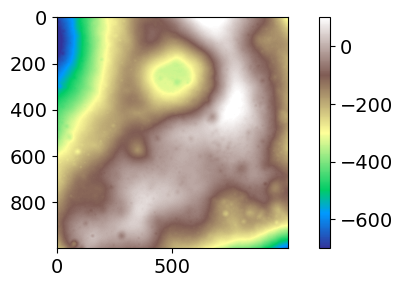

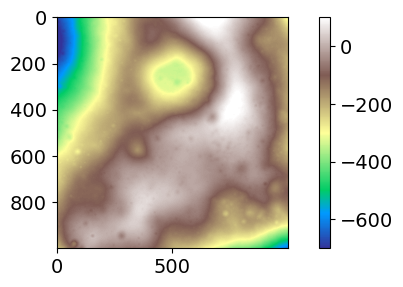

In [12]:
L = landmark.Landmark("output/moon/Haworth_final_adj_5mpp_surf_10km.lmk")
plt.imshow(L.ele, cmap='terrain')
plt.colorbar()
plt.clim(-700, 100)

plt.figure()
L = landmark.Landmark("output/moon/Haworth_final_adj_5mpp_surf_tif.lmk")
plt.imshow(L.ele, cmap='terrain')
plt.colorbar()
plt.clim(-700, 100)

Do the same for the other map.

In [13]:
!$BUILD_DIR/create_landmark \
    -geotif_file Lunar_LROnac_Haworth_sfs-dem_1m_v3.tif \
    -lmk_file output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_tif.lmk \
    -lmk_width_meters 10000 \
    -lmk_height_meters 10000 \
    -lmk_res 10 \
    -lmk_center_lat -86.8 \
    -lmk_center_long 338.0

Polar Stereographic Projection Detected
Creating landmark with empty surface reflectance map.
 0.374606593416372  0.927183854566601  0.000000000000000
 0.925738159047553 -0.374022494511522  0.055821451814038
 0.051756748860443 -0.020911083903613 -0.998440767155154


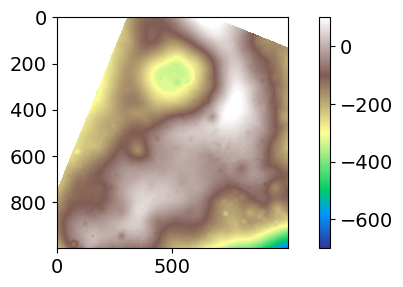

In [14]:
L = landmark.Landmark("output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_tif.lmk")
plt.imshow(L.ele, cmap='terrain')
plt.colorbar()
plt.clim(-700, 100)
plt.show()

### Step 2. Render map

`create_landmark`'s output will have an empty surface reflectance map. To create proxies for the surface reflectance values, we use the [Blender API]() to render the map.

First, we must make a polygon mesh from the landmark file using the `landmark_2_point` executable. Use the -frame LOCAL option for rendering with the Blender script. It uses the coordinate system of the tangent plane which centers the mesh at the origin and makes it easier to compute the sun angle.

In [15]:
!$BUILD_DIR/landmark_2_point \
-landmark output/moon/Haworth_final_adj_5mpp_surf_tif.lmk \
-ply output/moon/Haworth_final_adj_5mpp_surf_tif.ply \
-frame LOCAL

                 #! LVS Map v3.0
Landmark file saved at output/moon/Haworth_final_adj_5mpp_surf_tif.ply


After generating the mesh, render with `render_ply.py`. 

You will need to choose a sun angle to render from. If you are comparing to a map that has associated orbital imagery, use a sun angle that matches the imagery. In this demo, we are comparing two DEMs that do not have a surface reflectance map based on orbital imagery, so we can choose any sun angle.  

For the demo, I chose sun elevation 30 degrees and azimuth 120 degrees. These are not realistic values for the south pole region, but the output will have fewer shadows which will give us better map coverage in the validation step.

In [16]:
!python $PYTHON_SCRIPT_DIR/render_ply.py \
    output/moon/Haworth_final_adj_5mpp_surf_tif.ply \
    30 120 \
    output/moon/Haworth_final_adj_5mpp_surf_tif_rendered.png \
    -height 1000 \
    -width 1000 \
    -resolution 10

PLY import of 'Haworth_final_adj_5mpp_surf_tif.ply' took 213.87 ms
Fra:1 Mem:105.19M (Peak 105.19M) | Time:00:00.00 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | Haworth_final_adj_5mpp_surf_tif
Fra:1 Mem:259.47M (Peak 274.73M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Initializing
Fra:1 Mem:259.33M (Peak 274.73M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Waiting for render to start
Fra:1 Mem:259.33M (Peak 274.73M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Loading render kernels (may take a few minutes the first time)
Fra:1 Mem:259.33M (Peak 274.73M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Scene
Fra:1 Mem:259.33M (Peak 274.73M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Shaders
Fra:1 Mem:259.42M (Peak 274.73M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Procedurals
Fra:1 Mem:259.42M (Peak 274.73M) | Time:00:00.03 | Mem:0.00M, P

After rendering with Blender, the generated png file needs to be added to the landmark file. For this, we can use the add_srm executable.

In [17]:
!$BUILD_DIR/add_srm \
  -input output/moon/Haworth_final_adj_5mpp_surf_tif.lmk \
  -output output/moon/Haworth_final_adj_5mpp_surf_tif_rendered.lmk \
  -srm output/moon/Haworth_final_adj_5mpp_surf_tif_rendered.png

                 #! LVS Map v3.0
Landmark file written to: output/moon/Haworth_final_adj_5mpp_surf_tif_rendered.lmk


These steps will produce several files. 

- `Haworth_final_adj_5mpp_surf_tif_rendered.lmk` a landmark file with rendered surface reflectance map
- `Haworth_final_adj_5mpp_surf_tif_rendered.txt` the ASCII header file for the landmark file
- `Haworth_final_adj_5mpp_surf_tif_rendered.png` an image file containing the rendered area

Your png output should look like 

![rendered Site01 Map](../imgs/Haworth_final_adj_5mpp_surf_tif_rendered.png)

LMK_BODY 1
LMK_ID b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
LMK_SIZE 1000 1000
LMK_RESOLUTION 10.0
LMK_ANCHOR_POINT 90014.89640300615 -36368.37886264924 -1736479.670777188
LMK_ANCHOR_PIXEL 500.0 500.0
LMK_WORLD_2_MAP_ROT 0.3746065934166607 0.927183854566485 0.0
LMK_WORLD_2_MAP_ROT 0.9257381590476602 -0.37402249451156055 0.05582145181199273
LMK_WORLD_2_MAP_ROT 0.051756748858540716 -0.02091108390286288 -0.9984407671552687



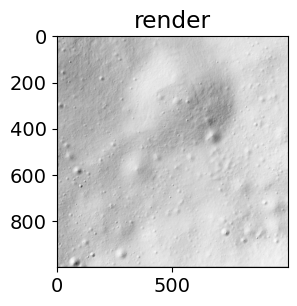

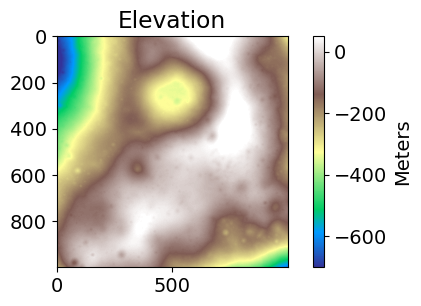

In [18]:
L0 = landmark.Landmark("output/moon/Haworth_final_adj_5mpp_surf_tif_rendered.lmk")

plt.figure()
plt.imshow(L0.srm, cmap='gray')
plt.title("render")

plt.figure()
plt.imshow(L0.ele, cmap='terrain')
im_ratio = L0.ele.shape[0]/L0.ele.shape[1]
cbar = plt.colorbar(fraction=0.046*im_ratio, pad=0.04)
cbar.set_label('Meters')
plt.clim(-700, 50)
plt.title("Elevation")

print(L0)

Do the same for the other map.

In [19]:
!$BUILD_DIR/landmark_2_point \
-landmark output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_tif.lmk \
-ply output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_rendered.ply \
-frame LOCAL

!python $PYTHON_SCRIPT_DIR/render_ply.py \
    output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_rendered.ply \
    30 120 \
    output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_rendered.png \
    -height 1000 \
    -width 1000 \
    -resolution 10

!$BUILD_DIR/add_srm \
  -input output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_tif.lmk \
  -output output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_rendered.lmk \
  -srm output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_rendered.png

                 #! LVS Map v3.0
Landmark file saved at output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_rendered.ply
PLY import of 'Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_rendered.ply' took 207.61 ms
Fra:1 Mem:93.10M (Peak 93.10M) | Time:00:00.00 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_rendered
Fra:1 Mem:227.40M (Peak 240.69M) | Time:00:00.02 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Initializing
Fra:1 Mem:227.27M (Peak 240.69M) | Time:00:00.02 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Waiting for render to start
Fra:1 Mem:227.27M (Peak 240.69M) | Time:00:00.02 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Loading render kernels (may take a few minutes the first time)
Fra:1 Mem:227.27M (Peak 240.69M) | Time:00:00.02 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Scene
Fra:1 Mem:227.27M (Peak 240.69M) | Time:00:00.02 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Shaders
Fra:1 Mem:227.35M (Peak 2

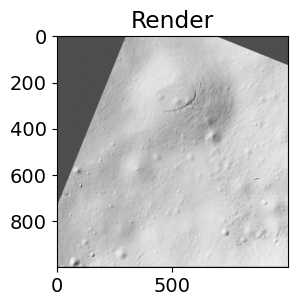

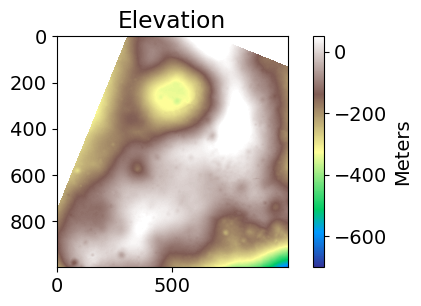

LMK_BODY 1
LMK_ID b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
LMK_SIZE 1000 1000
LMK_RESOLUTION 10.0
LMK_ANCHOR_POINT 90014.90390759883 -36368.381894701495 -1736479.8155484772
LMK_ANCHOR_PIXEL 500.0 500.0
LMK_WORLD_2_MAP_ROT 0.37460659341637237 0.9271838545666015 0.0
LMK_WORLD_2_MAP_ROT 0.9257381590475525 -0.37402249451152175 0.05582145181403788
LMK_WORLD_2_MAP_ROT 0.05175674886044345 -0.02091108390361291 -0.9984407671551543



In [20]:
L0 = landmark.Landmark("output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_rendered.lmk")

plt.figure()
plt.imshow(L0.srm, cmap='gray')
plt.title("Render")
plt.show()

plt.figure()
plt.imshow(L0.ele, cmap='terrain')
im_ratio = L0.ele.shape[0]/L0.ele.shape[1]
cbar = plt.colorbar(fraction=0.046*im_ratio, pad=0.04)
cbar.set_label('Meters')
plt.clim(-700, 50)
plt.title("Elevation")
plt.show()

print(L0)

### Step 3. Compare maps

Now, we're ready to compare maps.

In [21]:
!$BUILD_DIR/landmark_comparison \
  -l2 output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_rendered.lmk \
  -l1 output/moon/Haworth_final_adj_5mpp_surf_tif_rendered.lmk \
  -o output/moon/demo_comparison_lunar -c custom_parameters.txt

feature_match: 
  correlation_window_size: 35
  search_window_size: 71
  min_correlation: 0.300000
forstner_feature_detector: 
  min_dist_feature: 5.000000
  num_features: 600
  forstner_feature_window_size: 9
                 #! LVS Map v3.0
                 #! LVS Map v3.0
line = 0
num_matched_features 0
num_matched_features 1451
i = 0 j = 200
best feat for homography 1451
num_matched_features 2313
i = 0 j = 400
best feat for homography 2286
num_matched_features 2128
i = 0 j = 600
best feat for homography 2118
num_matched_features 1096
i = 0 j = 800
best feat for homography 1096
line = 200
num_matched_features 151
i = 200 j = 0
best feat for homography 151
num_matched_features 2455
i = 200 j = 200
best feat for homography 2447
num_matched_features 2527
i = 200 j = 400
best feat for homography 2320
num_matched_features 2589
i = 200 j = 600
best feat for homography 2564
num_matched_features 2346
i = 200 j = 800
best feat for homography 2346
line = 400
num_matched_features 1069
i = 400 

This command will produce a whole mess of raw images including 

- `demo_comparison_lunar_delta_x_1000by1000.raw`
- `demo_comparison_lunar_corr_1000by1000.raw`
- `demo_comparison_lunar_delta_z_1000by1000.raw`
- `demo_comparison_lunar_delta_y_1000by1000.raw`

Now we can use the python visualization tools (`scripts/visualize_corr.py`) to look at these results.

The `landmark_comparison` executable generates a vector field representing the displacement between the most highly correlated patches in the two DEMs. Each dimension of the vector field is stored as an image. Let's start by looking at the x-dimension, stored as `<prefix>_delta_x_wbyh.raw`

/Users/cmauceri/Workspace/LanderVisionSystem/github_landmark_tools/example/../scripts/python/landmark_tools/visualize_corr.py:109: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


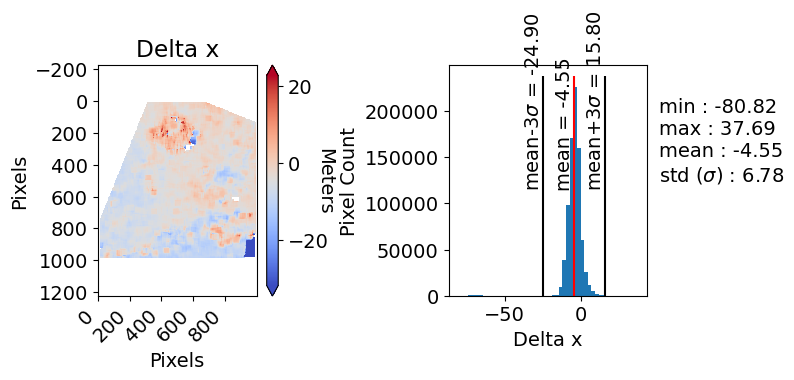

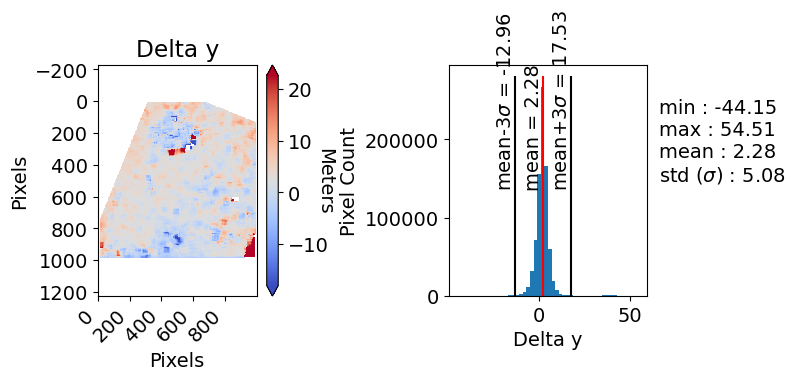

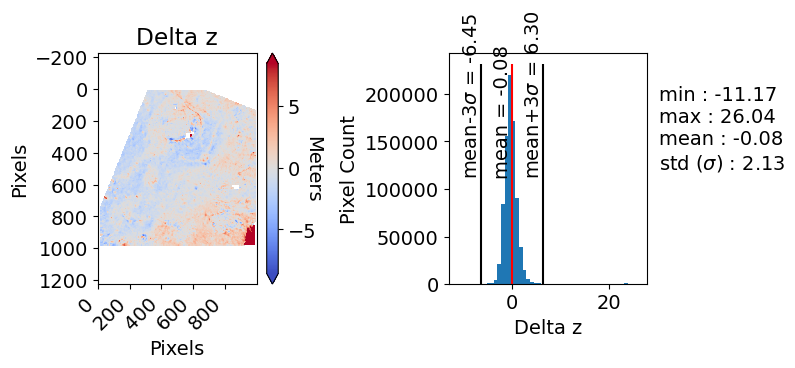

In [22]:
width = 1000
height = 1000
visualize_corr.displayAll("output/moon/demo_comparison_lunar", width, height, "output/moon/demo_comparison_lunar")

The output should look like this

![Example delta x output](../imgs/demo_comparison_lunar_x-histogram.png)
![Example delta y output](../imgs/demo_comparison_lunar_y-histogram.png)
![Example delta z output](../imgs/demo_comparison_lunar_z-histogram.png)

This looks very good. By looking at the mean and standard deviation, we see that the maps are aligned to within one pixel (10m) in all dimensions.

### Step 4. Fix map tie error (Optional) 

If the landmarks are not properly registered, the result of landmark_comparison will be sparse. To fix this error, use `landmark_registration -bm <base_map> -cm <child_map>` where -bm is the map that you want to register to, and -cm is the map that will be reprojected.

In [23]:
!$BUILD_DIR/landmark_registration

Reregister landmarks. The child landmark will be reprojected into the base landmark's reference frame.
Usage for landmark_register: 
------------------
  Required arguments:
    -base   <filename> - base landmark
    -child   <filename> - child landmark
    -parameters   <filename> - parameter file


In [24]:
!$BUILD_DIR/landmark_registration \
    -child output/moon/Haworth_final_adj_5mpp_surf_tif_rendered.lmk \
    -base output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_rendered.lmk \
    -parameters custom_parameters.txt

feature_match: 
  correlation_window_size: 35
  search_window_size: 71
  min_correlation: 0.300000
forstner_feature_detector: 
  min_dist_feature: 5.000000
  num_features: 600
  forstner_feature_window_size: 9
                 #! LVS Map v3.0
                 #! LVS Map v3.0
At feature i = 744 done length 9801
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
best feat for homography 534
# of RANSAC inliers 534
iter = 0
iter = 1
iter = 2
iter = 3
iter = 4
iter = 5
iter = 6
iter = 7
iter = 8
iter = 9
iter = 10
iter = 11
iter = 12
iter = 13
iter = 14
iter = 15
iter = 16
iter = 17
iter = 18
iter = 19
iter = 20
iter = 21
iter = 22
iter = 23
iter = 24
iter = 25
iter = 26
iter = 27
iter = 28
iter = 29
bestk 528
-140.4054913255095016 338.2978299833412166 -14.3896626913920045
 0.999999885796562 -0.000472602166248 -0.000071091883777
 0.000472617914153  0.999999863749268  0.000221661345009
 0.000070987116458 -0.000221694918992  0.99999997290

The realigned map is saved at `<child_map>_registered.lmk`, so in this case `Haworth_final_adj_5mpp_surf_10km_rendered.lmk_registered.lmk`. Let's use the newly registerd map to rerun the landmark comparison 

In [25]:
!$BUILD_DIR/landmark_comparison \
  -l2 output/moon/Haworth_final_adj_5mpp_surf_tif_rendered.lmk_registered.lmk \
  -l1 output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_rendered.lmk \
  -o output/moon/demo_comparison_lunar_registered -c custom_parameters.txt

feature_match: 
  correlation_window_size: 35
  search_window_size: 71
  min_correlation: 0.300000
forstner_feature_detector: 
  min_dist_feature: 5.000000
  num_features: 600
  forstner_feature_window_size: 9
                 #! LVS Map v3.0
                 #! LVS Map v3.0
line = 0
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
Ill conditioned peak
I

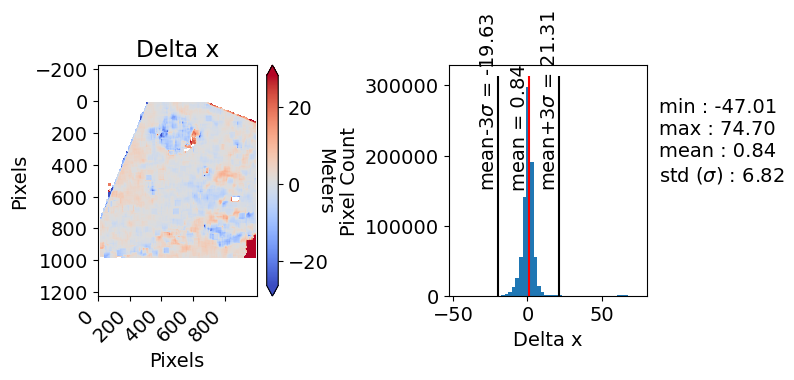

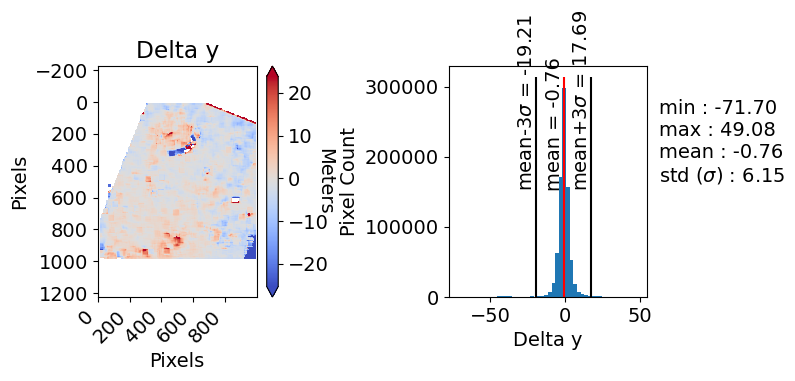

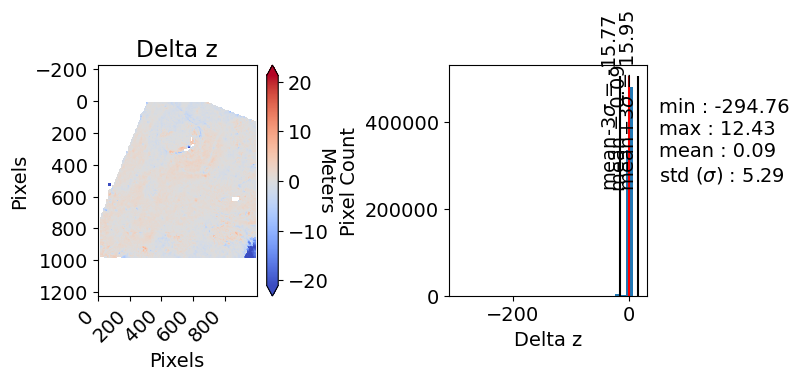

In [26]:
width = 1000
height = 1000
visualize_corr.displayAll("output/moon/demo_comparison_lunar_registered", width, height, "output/moon/demo_comparison_lunar_registered")

Your result should look like this

![Example delta x output](../imgs/demo_comparison_lunar_registered_x-histogram.png)
![Example delta y output](../imgs/demo_comparison_lunar_registered_y-histogram.png)
![Example delta z output](../imgs/demo_comparison_lunar_registered_z-histogram.png)

You can see that the registration decreased the mean bias on the x-dimension, but increased the mean bias on the y-dimension. However, since the pixel resolution is 10 m/pixel, this is considered to be very good alignment.

### Other useful functions.

Running `visualize_corr.py` from the command line will generate plots for all three dimensions and save them as .png files.

In [29]:
!python $PYTHON_SCRIPT_DIR/visualize_corr.py output/moon/demo_comparison_lunar 1000 1000

All figures have been generated.


`scripts/landmark.py` also contains python functions for loading and saving landmark files. These can be used to visualize the elevation map and the surface reflectance map. 

Text(0.5, 1.0, 'Surface Reflectance Map')

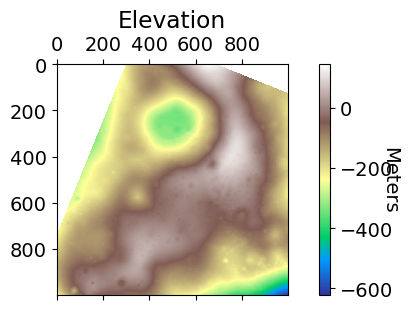

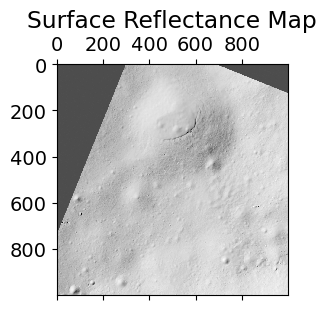

In [28]:
import landmark

L = landmark.Landmark("output/moon/Lunar_LROnac_Haworth_sfs-dem_1m_v3_10km_rendered.lmk")

fig, ax = plt.subplots()
cax = ax.matshow(L.ele, cmap='terrain')
ax.set_title("Elevation")
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel('Meters', rotation=270)

fig, ax = plt.subplots()
cax = ax.matshow(L.srm, cmap='gray')
ax.set_title("Surface Reflectance Map")